# Analysis of CMIP6, ERA5, and CloudSat


# Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#data_wrangling">2. Data Wrangling</a></li>
<li><a href="#exploratory">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusion">4. Conclusion</a></li>
<li><a href="#references">5. References</a></li>
</ul>

# 1. Introduction <a id='introduction'></a>


**Questions**
* How is the cloud phase and snowfall 


> **_NOTE:_** .

# 2. Data Wrangling <a id='data_wrangling'></a>


## Organize my data

- Define a prefix for my project (you may need to adjust it for your own usage on your infrastructure).
    - input folder where all the data used as input to my Jupyter Notebook is stored (and eventually shared)
    - output folder where all the results to keep are stored
    - tool folder where all the tools

The ERA5 0.25deg data is located in the folder `\scratch\franzihe\`, CloudSat at ...



In [1]:
import os
import pathlib
import sys
import socket
hostname = socket.gethostname()

abs_path = str(pathlib.Path(hostname).parent.absolute())
WORKDIR = abs_path[:- (len(abs_path.split('/')[-2] + abs_path.split('/')[-1])+1)]


if "mimi" in hostname:
    print(hostname)
    DATA_DIR = "/mn/vann/franzihe/"
    # FIG_DIR = "/uio/kant/geo-geofag-u1/franzihe/Documents/Figures/ERA5/"
    FIG_DIR = f"/uio/kant/geo-geofag-u1/franzihe/Documents/Python/globalsnow/CloudSat_ERA5_CMIP6_analysis/Figures/"
elif "glefsekaldt" in hostname: 
    DATA_DIR = "/home/franzihe/Data/"
    FIG_DIR = "/home/franzihe/Documents/Figures/ERA5/"

INPUT_DATA_DIR = os.path.join(DATA_DIR, 'input')
OUTPUT_DATA_DIR = os.path.join(DATA_DIR, 'output')
UTILS_DIR = os.path.join(WORKDIR, 'utils')
FIG_DIR_mci = os.path.join(FIG_DIR, 'McIlhattan/')

sys.path.append(UTILS_DIR)
# make figure directory
try:
    os.mkdir(FIG_DIR)
except OSError:
    pass

try:
    os.mkdir(FIG_DIR_mci)
except OSError:
    pass

mimi.uio.no


## Import python packages
- `Python` environment requirements: file [requirements_globalsnow.txt](../../requirements_globalsnow.txt) 
- load `python` packages from [imports.py](../../utils/imports.py)
- load `functions` from [functions.py](../../utils/functions.py)


In [2]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
from imports import(xr, ccrs, cy, plt, glob, cm, fct, np, pd, add_cyclic_point, TwoSlopeNorm, linregress)
# from matplotlib.lines import Line2D
# from matplotlib.patches import Patch
# from sklearn.metrics import r2_score

# plt.rcParams['text.usetex'] = True
from seaborn import set_context


xr.set_options(display_style='html')

In [3]:
# reload imports
%load_ext autoreload
%autoreload 2

In [4]:
# plot cosmetics
set_context('paper', font_scale=1.5, rc={"lines.linewidth": 2})

## Open variables
Get the data requried for the analysis. 



In [5]:
dat_in = os.path.join(OUTPUT_DATA_DIR, 'CS_ERA5_CMIP6')

# make output data directory
# try:
#     os.mkdir(dat_out)
# except OSError:
#     pass

sic = xr.open_dataset(os.path.join(INPUT_DATA_DIR, 'AMSR2_sea_ice/40NS/AMSR2_IPSL-CM6A-LR_200701_201012.nc'))

In [6]:
ds_cs_2t = xr.open_mfdataset(sorted(glob(os.path.join(INPUT_DATA_DIR, 'cloudsat/aux_monthly_2t/cloudsat*.nc'))))
cs_2t = ds_cs_2t.temp_2m.groupby('time.season').mean('time')


In [7]:
ds_era_2t = xr.open_dataset('/mn/vann/franzihe/output/CS_ERA5_CMIP6/orig/era_500_orig_20070101-20101231.nc')
era_2t = ds_era_2t.tas.groupby('time.season').mean('time')


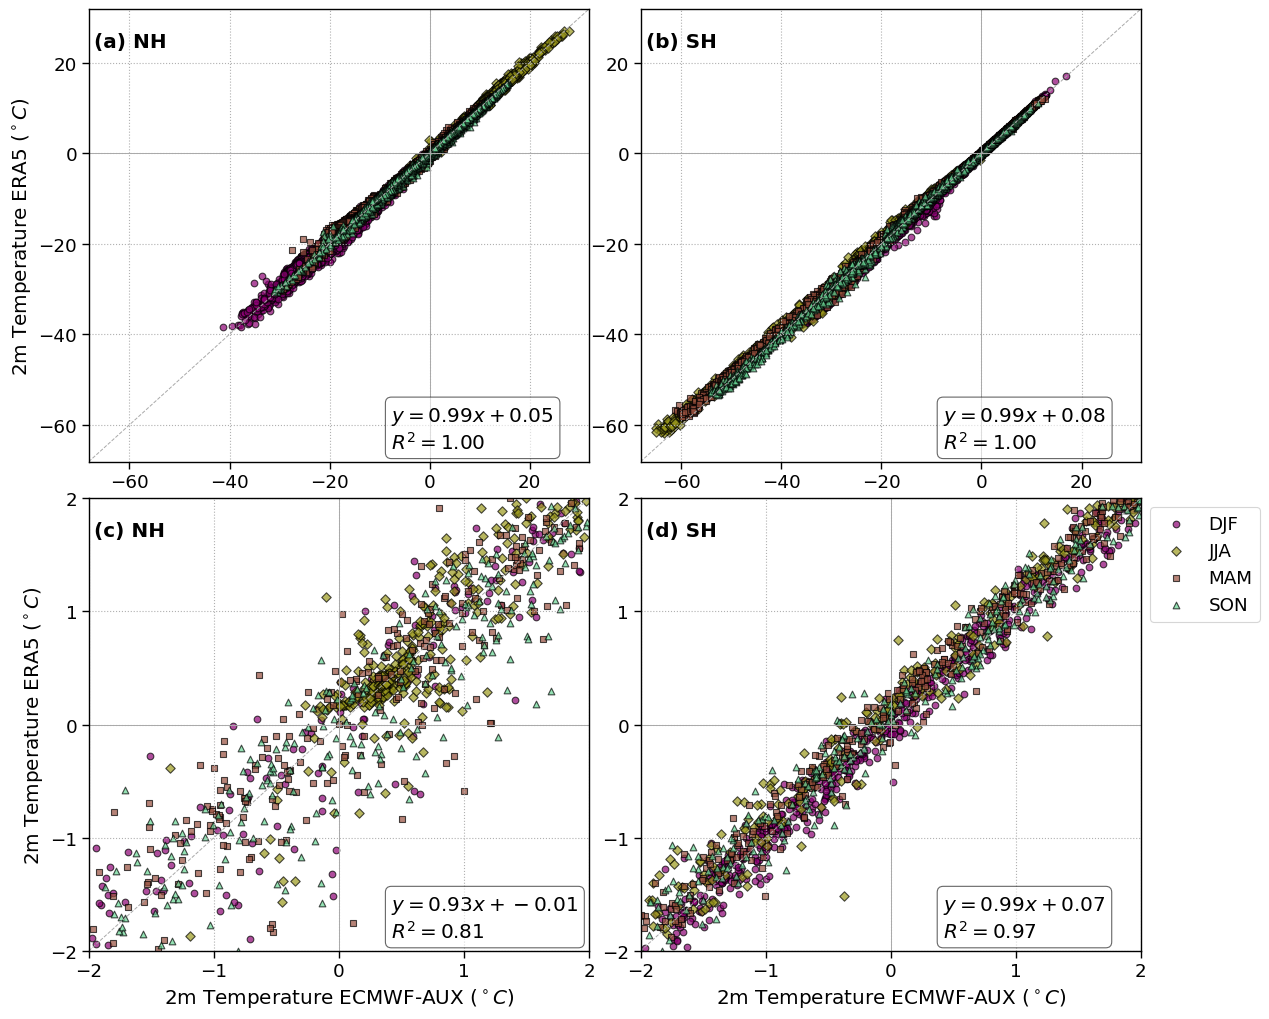

In [8]:

# Plotting with different markers and colors for each season
colors = cm.hawaii(range(0, 256, int(256 / 4) + 1))

season_colors = {
    "DJF": colors[0,:],
    "MAM": colors[1,:],
    "JJA": colors[2,:],
    "SON": colors[3,:]
}
season_markers = {
    "DJF": "o",  # Circle
    "MAM": "s",  # Square
    "JJA": "D",  # Diamond
    "SON": "^"     # Triangle
}

# fig, ax = plt.subplots(figsize=(10, 6))
# f, axsm = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=[15, 7.5])
f, axsm = plt.subplots(nrows=2, ncols=2, figsize=[12.5, 10])

for ax, k, hemisphere in zip(axsm.flatten(), range(len(fct.fig_label)), ['NH','SH', 'NH', 'SH']):
    ax.grid(linestyle=':')
    

    ax.text(0.01, 0.95, f'{fct.fig_label[k]} {hemisphere}', fontweight='bold', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
    # ax.set_xlabel('2m Temperature ECMWF-AUX (K)')

    ax.axvline(x=273.15-273.15, ymin=0, ymax=1, color='darkgrey', lw=.7)
    ax.axhline(y=273.15-273.15, xmin=0, xmax=1, color='darkgrey', lw=.7)


    # plot each seasons data
    lat_slice = slice(45,90) if hemisphere == 'NH' else slice(-90,-45)
    if k == 0 or k ==1:
        da_x = (cs_2t-273.15).sel(lat = lat_slice)
        da_y = (era_2t-273.15).sel(lat = lat_slice)
        # for season in cs_2t.season.values:
        #     ax.scatter(cs_2t.sel(season=season, lat=lat_slice),
        #             era_2t.sel(season=season, lat=lat_slice),
        #             color=season_colors[season],
        #             marker=season_markers[season],
        #             label=season,
        #             alpha=0.7,
        #             edgecolors="k"  # Add black edge for clarity
        #             )
        ax.set_xlim([205-273.15,305-273.15])
        ax.set_ylim([205-273.15,305-273.15])
    if k == 2 or k == 3:
        da_x = (cs_2t-273.15).sel(lat = lat_slice)
        da_x = da_x.where((da_x > -2) & (da_x < +2))
        
        da_y = (era_2t-273.15).sel(lat = lat_slice)
        da_y = da_y.where((da_y > -2) & (da_y < +2))
        
        ax.set_xlim([-2, +2])
        ax.set_ylim([-2, +2])
        ax.set_xticks(np.arange(-2,276-273.15))
        ax.set_yticks(np.arange(-2,276-273.15))
        
    # Remove NaN values in both x and y
    mask = ~np.isnan(da_x.values.ravel()) & ~np.isnan(da_y.values.ravel())
    x_clean = da_x.values.ravel()[mask]
    y_clean = da_y.values.ravel()[mask]
    # Perform polyfit on cleaned data
    slope, intercept, r_value, p_value, std_err = linregress(x_clean, y_clean)
    # print(f"Slope: {slope}, Intercept: {intercept}, Std err: {std_err}, R value: {r_value}")
    for season in cs_2t.season.values:
        ax.scatter(da_x.sel(season=season),
                   da_y.sel(season=season),
                   color=season_colors[season],
                    marker=season_markers[season],
                    label=season,
                    alpha=0.7,
                    edgecolors="k"  # Add black edge for clarity)
        )
    ax.plot([0, 1], [0, 1], ls='--', color='darkgrey', lw=.7,transform=ax.transAxes,)
    
    textstr = '\n'.join((
    r'$y=%.2f x + %.2f$' % (slope, intercept),
    r'$R^2=%.2f$' % (r_value**2, ),))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.6)#0.5)

    # place a text box in upper left in axes coords
    ax.text(0.605, 0.125, textstr, transform=ax.transAxes, #fontsize=14,
            verticalalignment='top', bbox=props)
   

axsm[0,0].set_ylabel('2m Temperature ERA5 ($^\circ C$)')
axsm[1,0].set_ylabel('2m Temperature ERA5 ($^\circ C$)')

axsm[1,0].set_xlabel('2m Temperature ECMWF-AUX ($^\circ C$)')
axsm[1,1].set_xlabel('2m Temperature ECMWF-AUX ($^\circ C$)')

axsm[1,1].legend(#loc='lower right', 
                 bbox_to_anchor=(1., 1.0))


plt.tight_layout(pad=0., w_pad=0., h_pad=0.)  ;
figname = f'CC_vs_ERA5_temp_NH_SH.png'
plt.savefig(FIG_DIR + figname, format='png', bbox_inches='tight', transparent=True)

In [9]:
ds_cmip_2t = xr.open_dataset('/mn/vann/franzihe/output/CS_ERA5_CMIP6/orig/cmip_500_orig_20070101-20101231.nc')
cmip_2t = ds_cmip_2t.tas.groupby('time.season').mean(('time','model'))


In [10]:
lwp_thresholds = [3, 5, 10, 15,]# 20]

In [11]:
dict_label = {
     # 'lcc_wo_snow': {'cb_label':'FsLCC (%)', 'levels':np.arange(0,110,10), 'vmin': 0, 'vmax':100, 'diff_levels':np.arange(-30,35,5), 'diff_vmin':-30, 'diff_vmax':30},
#      'lcc_w_snow':  {'cb_label':'FoS in sLCCs (%)', 'levels':np.arange(0,110,10), 'vmin': 0, 'vmax':100, 'diff_levels':np.arange(-60,65,5), 'diff_vmin':-60, 'diff_vmax':60},
#      'sf_eff':      {'cb_label':'SE in sLCCs (h$^{-1}$)', 'levels':np.arange(0,5.5,.5), 'vmin':0, 'vmax':5, 'diff_levels':np.arange(-1.2,1.4,.2), 'diff_vmin':-1.2, 'diff_vmax':1.2}#'Relative snowfall efficiency (h$^{-1}$)'
     
     'FLCC' : {'cb_label':'f$_{{LCC}}$ (%)',             'levels':np.arange(0,110.,10.), 'vmin':0, 'vmax': 100., 'vmax2': 100.,  'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100, 'bounds':np.linspace(-40,40,17), 'qrates': list(np.arange(-42.5, 42.5,5))},
     'FsLCC': {'cb_label':'f$_{{sLCC}}$ (%)',            'levels':np.arange(0,110.,10.), 'vmin':0, 'vmax': 100, 'vmax2': 65.,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100, 'bounds':np.arange(-25, 20, 5), 'qrates': list(np.arange(-27.5, 20, 5))}, 
     # 'FoP'  : {'cb_label':'FoP in LCCs (%)',      'levels':np.arange(0,105.,5.), 'vmin':0, 'vmax': 100,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100},
     'FoS'  : {'cb_label':'f$_{{snow}}$ (%)',     'levels':np.arange(0,110.,10.), 'vmin':0, 'vmax': 100, 'vmax2': 100.,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100, 'bounds':np.arange(-80, 20, 10), 'qrates':list(np.arange(-85, 25, 10))},
     # 'pr_eff': {'cb_label':'PE in sLCCs (h$^{-1}$)', 'levels':np.arange(0,550.,50.), 'vmin':0, 'vmax':500,   'diff_levels':np.arange(-120,140,20),   'diff_vmin':-120, 'diff_vmax':120},
     'FLCC-FsLCC': {'cb_label':'f$_{{LCC}}$ (%), f$_{{sLCC}}$ (%)',  'levels':np.arange(0,110.,10.), 'vmin':0, 'vmax': 100, 'vmax2': 65.,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100, 'bounds':np.linspace(-45,45,19), 'qrates': list(np.arange(-47.5,47.5,5))},
     'sf_eff': {'cb_label':'SE in sLCCs (h$^{-1}$)','levels':np.arange(0,5.5,.5), 'vmin':0, 'vmax': 5, 'vmax2': 7.5,   'diff_levels':np.arange(-1.2,1.4,.2),   'diff_vmin':-1.2, 'diff_vmax':1.2, 'bounds':np.linspace(-2,2,21), 'qrates': list(np.arange(-2.1,2.1,0.2))},
     # 'sf_eff': {'cb_label':'SE in sLCCs (h$^{-1}$)','levels':np.arange(0,9.5,.5), 'vmin':0, 'vmax': 9,   'diff_levels':np.arange(-1.2,1.4,.2),   'diff_vmin':-1.2, 'diff_vmax':1.2},
     }


In [12]:
# Initialize dictionaries to store data and regression results
ratios = {}
regression = {}

# Loop through different LWP thresholds
for lwp_threshold in lwp_thresholds:
    # Load data into ratios dictionary
    ratios[lwp_threshold] = xr.open_mfdataset(glob(f'{dat_in}/ratios_500/*LWP{lwp_threshold}_*.nc'))
    
    # Initialize a dictionary to store linear regression results
    linregress_results = {}
    # Perform linear regression for each variable
    for var_name in dict_label.keys():
        linregress_results[var_name] = fct.get_linear_regression_hemisphere(ratios[lwp_threshold], var_name)
    
    # Concatenate regression results along the 'variable' dimension
    regression[lwp_threshold] = xr.concat(objs=list(linregress_results.values()),
                                   dim =list(linregress_results.keys())).rename({"concat_dim":"variable"})
    # Reindex the data according to the desired model order
    regression[lwp_threshold] = regression[lwp_threshold].reindex({'model':['ERA5', 'MIROC6', 'CanESM5', 'AWI-ESM-1-1-LR',
                                                              'MPI-ESM1-2-LR', 'UKESM1-0-LL', 'HadGEM3-GC31-LL', 'CNRM-CM6-1',
                                                              'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'IPSL-CM5A2-INCA']})
# Concatenate data and regression results along the 'threshold' dimension
ratios = xr.concat(objs=list(ratios.values()), dim=lwp_thresholds).rename({"concat_dim":"threshold"})
ratios = ratios.reindex(season=['DJF', 'MAM', 'JJA', 'SON'])


regression = xr.concat(objs=list(regression.values()), dim=lwp_thresholds).rename({"concat_dim":"threshold"})


In [13]:
# Initialize dictionaries to store data and regression results
ratios_mci = {}
regression_mci = {}

# Loop through different LWP thresholds
for lwp_threshold in lwp_thresholds:
    # Load data into ratios dictionary
    ratios_mci[lwp_threshold] = xr.open_mfdataset(glob(f'{dat_in}/ratios_500_mci/*LWP{lwp_threshold}_*.nc'))
    
    # Initialize a dictionary to store linear regression results
    linregress_results = {}
    # Perform linear regression for each variable
    for var_name in dict_label.keys():
        linregress_results[var_name] = fct.get_linear_regression_hemisphere(ratios_mci[lwp_threshold], var_name)
    
    # Concatenate regression results along the 'variable' dimension
    regression_mci[lwp_threshold] = xr.concat(objs=list(linregress_results.values()),
                                   dim =list(linregress_results.keys())).rename({"concat_dim":"variable"})
    # Reindex the data according to the desired model order
    regression_mci[lwp_threshold] = regression_mci[lwp_threshold].reindex({'model':['ERA5', 'MIROC6', 'CanESM5', 'AWI-ESM-1-1-LR',
                                                              'MPI-ESM1-2-LR', 'UKESM1-0-LL', 'HadGEM3-GC31-LL', 'CNRM-CM6-1',
                                                              'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'IPSL-CM5A2-INCA']})
# Concatenate data and regression results along the 'threshold' dimension
ratios_mci = xr.concat(objs=list(ratios_mci.values()), dim=lwp_thresholds).rename({"concat_dim":"threshold"})
ratios_mci = ratios_mci.reindex(season=['ASO', 'NDJ', 'FMA', 'MJJ'])


regression_mci = xr.concat(objs=list(regression_mci.values()), dim=lwp_thresholds).rename({"concat_dim":"threshold"})


In [14]:
# ratios = xr.open_mfdataset(glob(f'{dat_in}/ratios_500/*LWP{lwp_threshold}_*.nc'))
# ratios_mci = xr.open_mfdataset(glob(f'{dat_in}/ratios_500_mci/*LWP{lwp_threshold}_*.nc'))

In [15]:
# # calculate linear regression and create dataset with values
# linregress = dict()
# for var_name in (dict_label.keys()):
#     linregress[var_name] = fct.get_linear_regression_hemisphere(ratios.sel(threshold=lwp_threshold), var_name)


# _ds = list(linregress.values())
# _coord = list(linregress.keys())

# regression = xr.concat(objs=_ds, dim=_coord).rename({"concat_dim":"variable"})
# regression = regression.reindex({'model':['ERA5', 'MIROC6', 'CanESM5', 'AWI-ESM-1-1-LR',
#                                           'MPI-ESM1-2-LR', 'UKESM1-0-LL', 'HadGEM3-GC31-LL', 'CNRM-CM6-1',
#                                           'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'IPSL-CM5A2-INCA']})



In [16]:
# # calculate linear regression and create dataset with values
# linregress_mci = dict()
# for var_name in (dict_label.keys()):
#     linregress_mci[var_name] = fct.get_linear_regression_hemisphere(ratios_mci, var_name)


# _ds = list(linregress_mci.values())
# _coord = list(linregress_mci.keys())

# regression_mci = xr.concat(objs=_ds, dim=_coord).rename({"concat_dim":"variable"})
# regression_mci = regression_mci.reindex({'model':['ERA5', 'MIROC6', 'CanESM5', 'AWI-ESM-1-1-LR',
#                                           'MPI-ESM1-2-LR', 'UKESM1-0-LL', 'HadGEM3-GC31-LL', 'CNRM-CM6-1',
#                                           'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'IPSL-CM5A2-INCA']})

In [17]:
# .sel(model = ['MIROC6', 'CanESM5', 'AWI-ESM-1-1-LR',
#                                                     'MPI-ESM1-2-LR', 'UKESM1-0-LL', 'HadGEM3-GC31-LL', 'CNRM-CM6-1',
#                                                     'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'IPSL-CM5A2-INCA'])
        

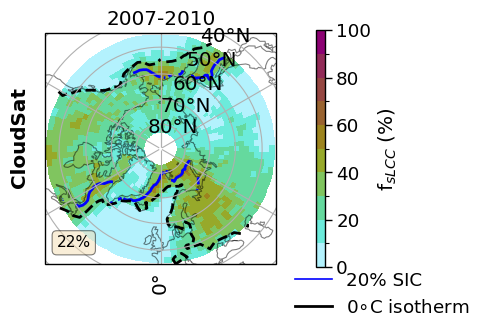

In [18]:
hemisphere = 'NH'
lat_extent = 45.

value = ratios.sel(threshold=lwp_threshold)['FsLCC_season'].sel(model='CloudSat', season='DJF')
value_sic = sic['z_season_mean'].sel( season='DJF')
temperature_da = cs_2t.sel(season='DJF')
hemi_glob = ratios.sel(threshold=lwp_threshold)['FsLCC_season_mean'].sel(model='CloudSat', season='DJF')
projection = fct.create_projection(hemisphere)
f, axsm = plt.subplots(nrows=1, 
                            ncols=1, 
                            subplot_kw={'projection': projection}, 
                            figsize=[4, 3], sharex=True, sharey=True)

fct.setup_axes(axsm, hemisphere, lat_extent)
cmap = cm.hawaii_r
levels = dict_label['FoS']['levels']
norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
axsm.text(-0.07, 0.55, 'CloudSat', 
                va='bottom', 
                ha='center', 
                rotation='vertical', 
                rotation_mode='anchor', 
                transform=axsm.transAxes, 
                fontweight='bold')

val = value.sel(lat=slice(45,90)) if hemisphere == 'NH' else value.sel(lat=slice(-90,-45))
cf = axsm.pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))), 
                            transform=ccrs.PlateCarree(), 
                            cmap=cmap, 
                            norm=norm)
contour = value_sic.plot.contour(ax=axsm, transform=ccrs.PlateCarree(), x='lon', y='lat', levels = [20., ], lw=1.2, add_colorbar=False, colors = 'blue')
isotherm = axsm.contour(
    temperature_da.lon,
    temperature_da.lat,
    temperature_da,
    transform=ccrs.PlateCarree(),
    levels=[273.15],
    colors="k",  # Color for the isotherm line
    linewidths=2,
    linestyles="--"  # Dashed line for visibility
)


fct.add_text_box(axsm, hemi_glob.sel(hemisphere=hemisphere,), 'FoS')
axsm.set_title('2007-2010')

cbaxes = f.add_axes([0.9, 0.1, 0.0225, 0.79])
cb_label = dict_label['FsLCC']['cb_label']
extend = None
plt.colorbar(cf, cax=cbaxes, shrink=0.5,extend=extend, orientation='vertical', label=cb_label)



legend_elements = [fct.Line2D([0], [0], color='b', lw=1.2, label='20% SIC'),
                   fct.Line2D([0], [1], color='k', lw=2., label='0$\circ$C isotherm')
                   ]
leg = axsm.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.0), loc=2, borderaxespad=0.)#loc='best')
leg.get_frame().set_edgecolor('b')
leg.get_frame().set_linewidth(0.0)

# axsm.clabel(contour, fmt='%1.1f', fontsize=12)# cbar = plt.colorbar(contour, )#cax=axsm, orientation='vertical',pad=0.05, shrink = 0.8)
#cbar.set_label('Sea ice concentration (%)',fontsize=16)

# ratios.sel(threshold=lwp_threshold)['FoS_year'].sel(model='ERA5').plot()

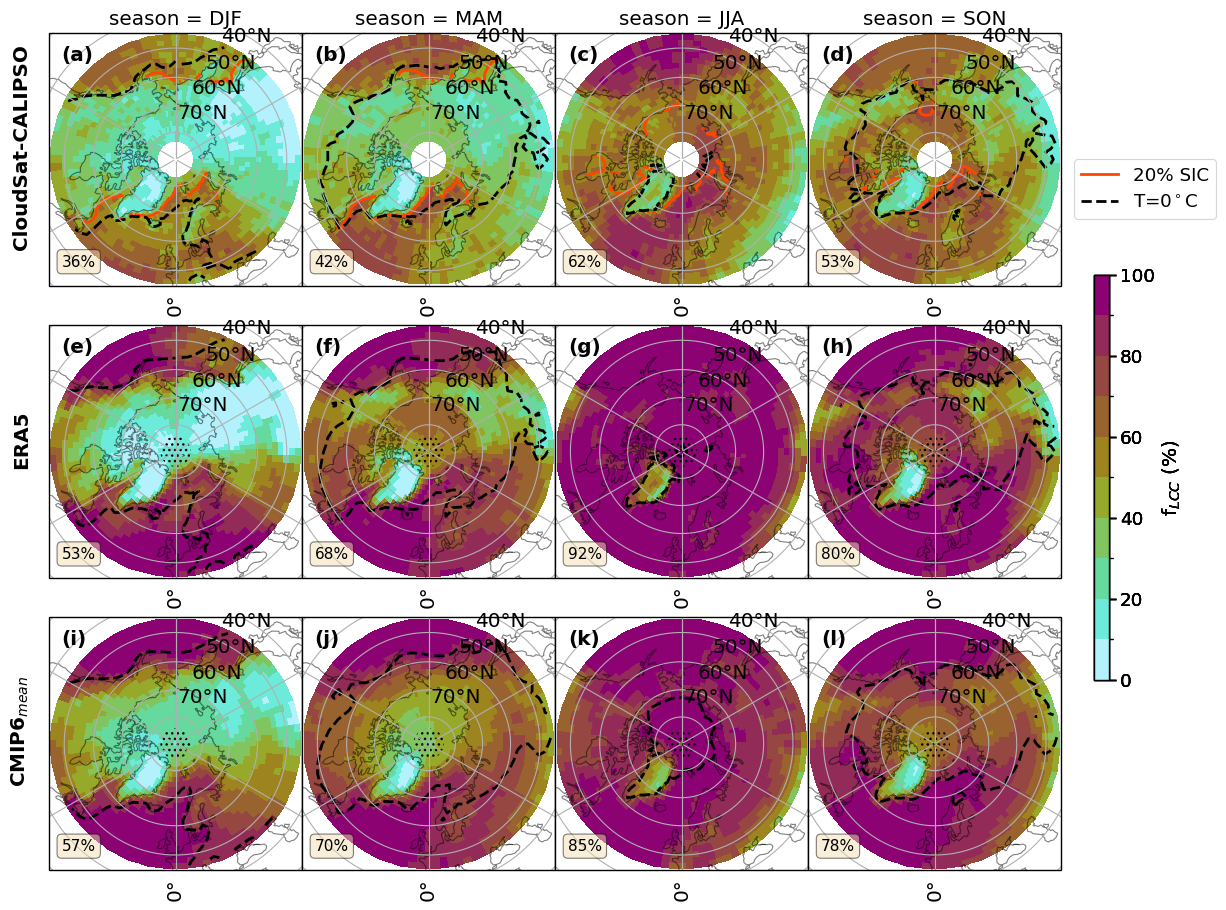

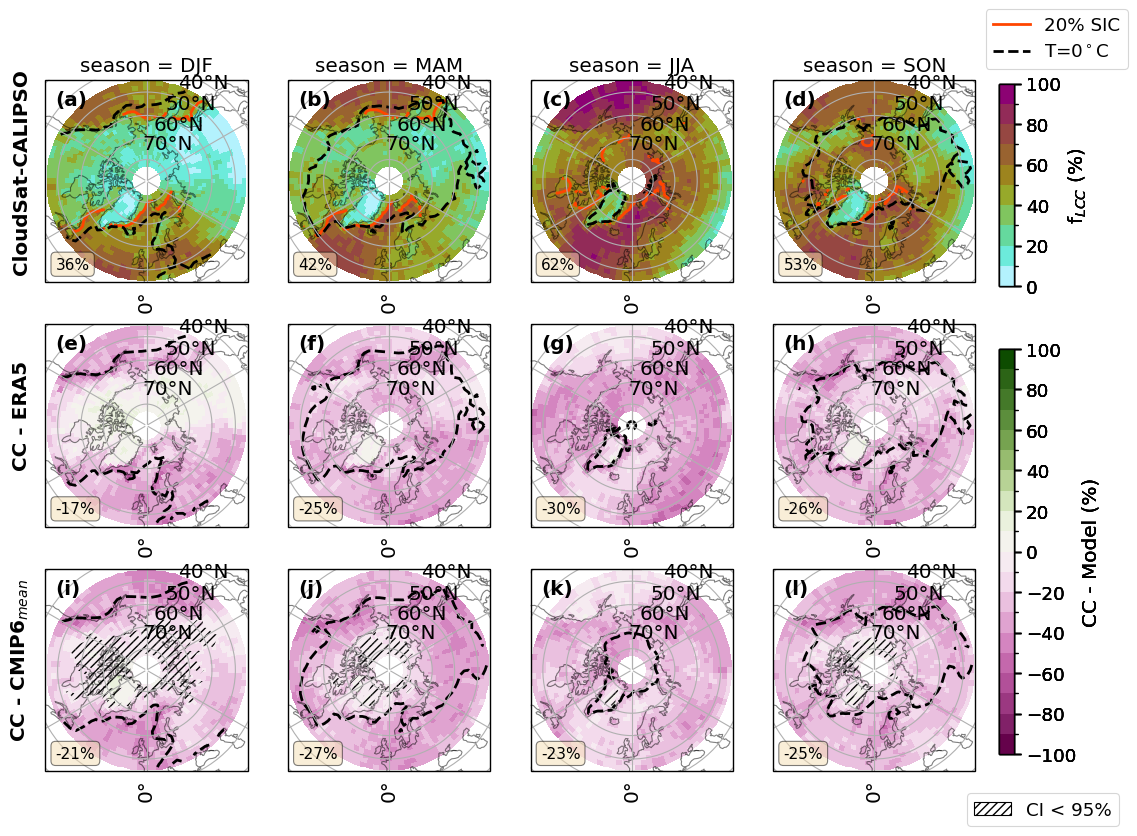

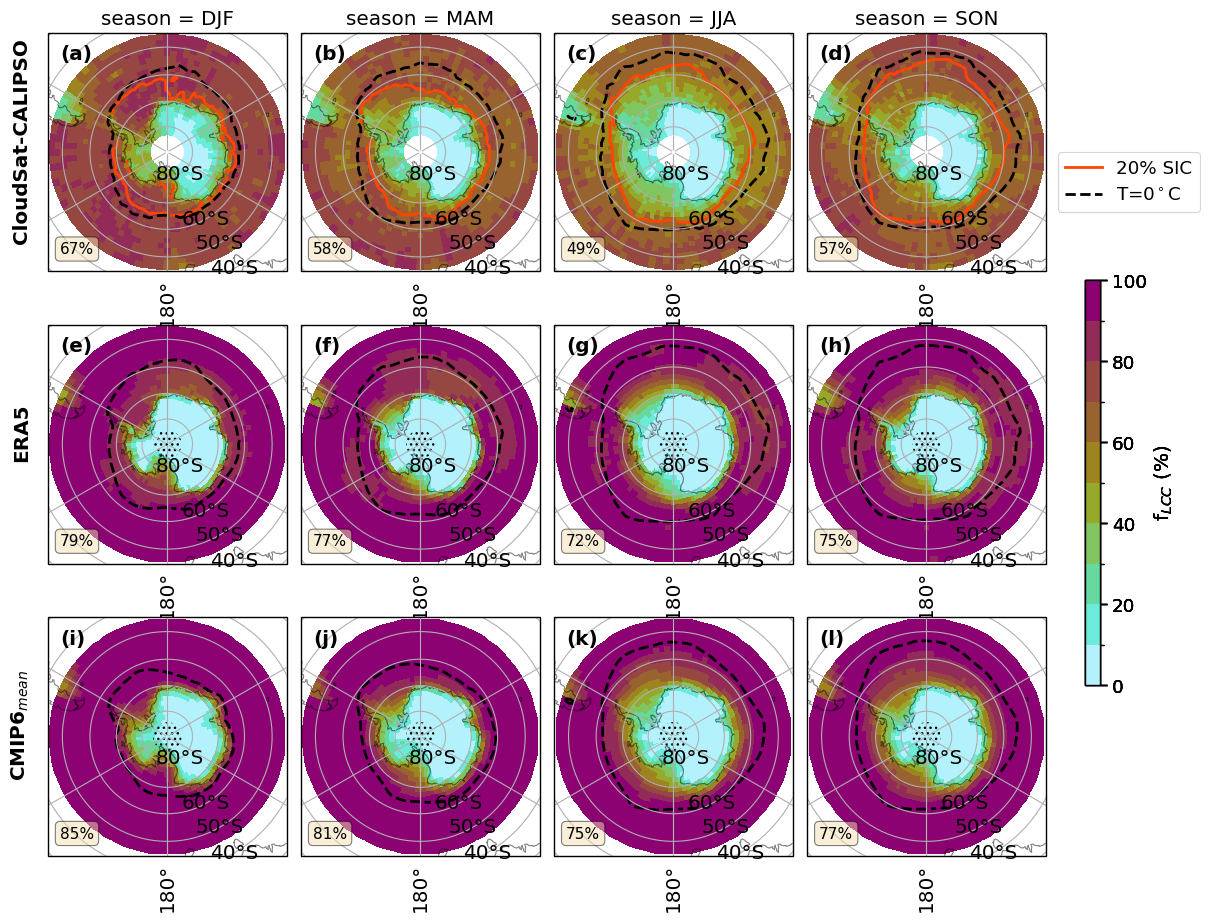

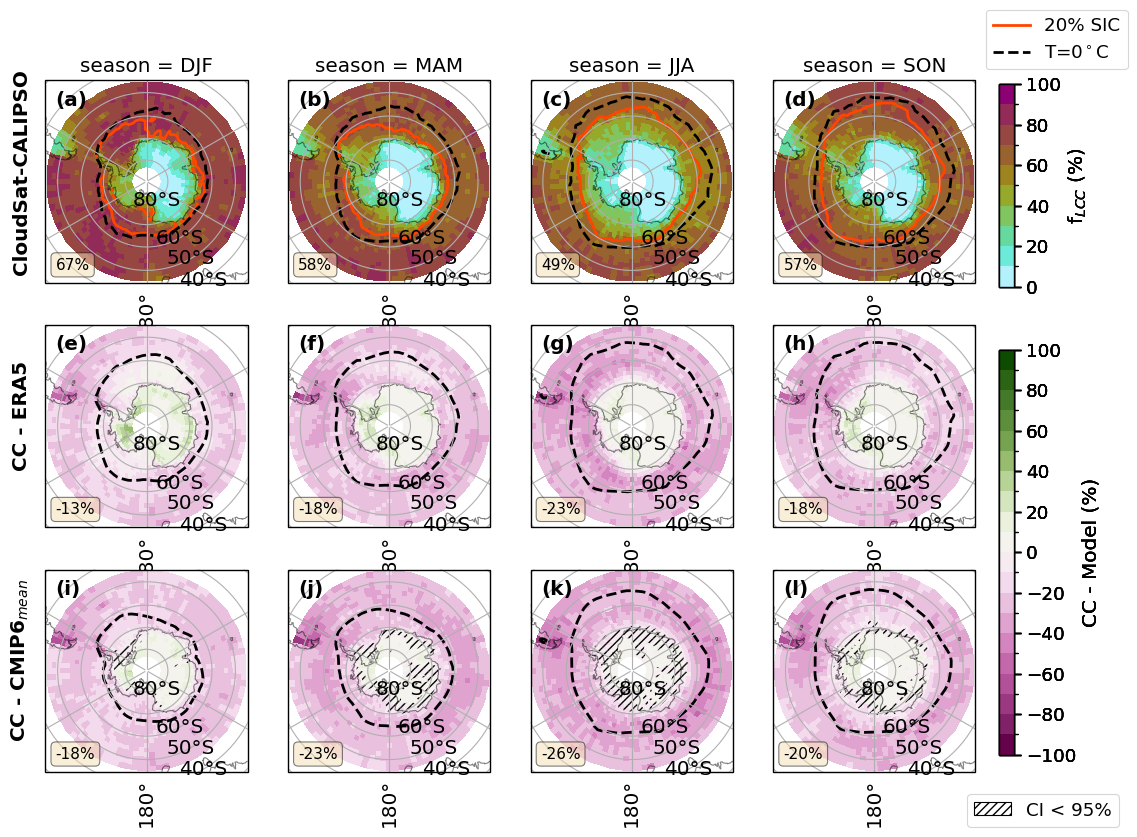

In [19]:
# for var_name in (dict_label.keys()):
for var_name in ['FLCC']:#         'FLCC','FLCC-FsLCC','sf_eff', 'FsLCC','FoS',]:
    
#     # for lwp_threshold in lwp_thresholds:
    for lwp_threshold in [5,]:
        # print(f'plot {var_name} for {lwp_threshold}')
        F_DIR = os.path.join(FIG_DIR,f'CS_ERA5_CMIP6_{lwp_threshold}/')
        F_DIR_mci = os.path.join(FIG_DIR_mci,f'CS_ERA5_CMIP6_{lwp_threshold}/')
        try:
            os.mkdir(F_DIR)
        except OSError:
            pass
        try:
            os.mkdir(F_DIR_mci)
        except OSError:
            pass
        fct.plt_spatial_season_var(ratios.sel(threshold=lwp_threshold), var_name, dict_label, sic['z_season_mean'],cs_2t,era_2t,cmip_2t, F_DIR, 45, lwp_threshold)
#         # # fct.plt_spatial_season_var(ratios_mci.sel(threshold=lwp_threshold), var_name, dict_label, F_DIR_mci, 66, lwp_threshold)
            
        # plot monthly model variation
        # fct.plt_monthly_model_variation(ratios.sel(threshold=lwp_threshold), var_name, dict_label[var_name],F_DIR, lwp_threshold)
#         # # # fct.plt_monthly_model_variation(ratios_mci.sel(threshold=lwp_threshold), var_name, dict_label[var_name],F_DIR_mci, lwp_threshold)
            
        # fct.plt_monthly_interannual_variation(ratios.sel(threshold=lwp_threshold), var_name, lwp_threshold, F_DIR, dict_label[var_name])
#         # # # fct.plt_monthly_interannual_variation(ratios_mci.sel(threshold=lwp_threshold), var_name, lwp_threshold, F_DIR_mci, dict_label[var_name])
            
        
        # # fct.plt_absolute_difference_season(ratios.sel(threshold=lwp_threshold), var_name, lwp_threshold, dict_label[var_name], F_DIR)
        # fct.plt_difference_season(ratios.sel(threshold=lwp_threshold), var_name, lwp_threshold, dict_label[var_name], F_DIR)
        # # fct.plt_heatmap_all_models_season(ratios.sel(threshold=lwp_threshold), var_name, lwp_threshold, dict_label[var_name],  F_DIR)
        
#         # plot scatter CloudSat vs model
        # fct.plt_scatter_obs_model(ratios.sel(threshold=lwp_threshold), regression.sel(threshold=lwp_threshold), var_name, dict_label[var_name], F_DIR, lwp_threshold)
#         # # fct.plt_scatter_obs_model(ratios_mci.sel(threshold=lwp_threshold), regression_mci.sel(threshold=lwp_threshold), var_name, dict_label[var_name], F_DIR_mci, lwp_threshold)

#         # plot variable for individual model
        # fct.plt_spatial_season_all_models(ratios.sel(threshold=lwp_threshold), var_name, dict_label, F_DIR, 45)
#         # # # fct.plt_spatial_season_all_models(ratios_mci.sel(threshold=lwp_threshold), var_name, dict_label, F_DIR_mci, 66)
    
    # plot difference between CloudSat and ERA5, CMIP6 mean for lwp threshold comparison
    # if var_name == 'FLCC' or var_name == 'FsLCC' or var_name == 'FoS':
    #     for hemisphere in ['NH', 'SH']:
    #         fct.plt_spatial_annual_difference(ratios, hemisphere, var_name, dict_label[var_name], FIG_DIR, 45, lwp_thresholds)
        #     fct.plt_spatial_annual_difference(ratios_mci, hemisphere, var_name, dict_label[var_name], F_DIR_mci, 45, lwp_thresholds)

# for lwp_threshold in lwp_thresholds:
# #     # plot R2 values for all values and both hemispheres
#     F_DIR = os.path.join(FIG_DIR,f'CS_ERA5_CMIP6_{lwp_threshold}/')
#     fct.plt_R2_heatmap_season(regression.sel(threshold=lwp_threshold), dict_label, F_DIR, lwp_threshold)
# #     # fct.plt_R2_heatmap_season(regression_mci.sel(threshold=lwp_threshold), dict_label, F_DIR_mci, lwp_threshold)


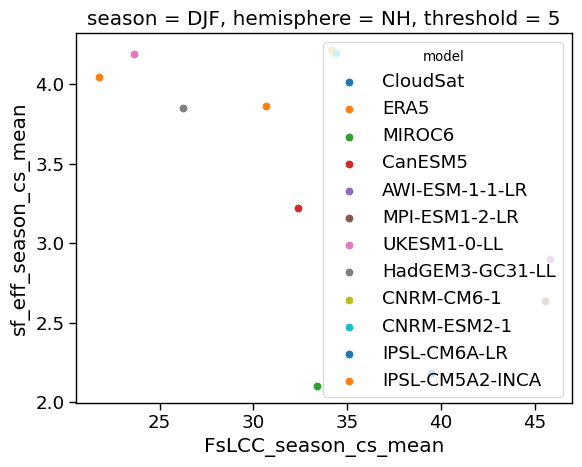

In [16]:
x=ratios['FsLCC'+'_season_cs_mean'].sel(threshold=5, hemisphere='NH', season='DJF')
y=ratios['sf_eff'+'_season_cs_mean'].sel(threshold=5, hemisphere='NH', season='DJF')

xr.plot.scatter(ratios.sel(threshold=5, hemisphere='NH', season='DJF'), x='FsLCC'+'_season_cs_mean', y='sf_eff'+'_season_cs_mean', hue='model', hue_style='discrete', cmap=cm.hawaii)

In [17]:
_in2 = os.path.join(INPUT_DATA_DIR, 'cmip6_hist/')

In [18]:
da_sat_NH = pd.read_csv(glob(f'{_in2}/*satellite*NH*')[0], index_col=0)
da_sat_SH = pd.read_csv(glob(f'{_in2}/*satellite*SH*')[0], index_col=0)
da_sat_NH.set_axis(list(np.arange(-60, 6,1)+273.15), axis='columns', inplace=True)
da_sat_SH.set_axis(list(np.arange(-60, 6,1)+273.15), axis=1, inplace=True)

da = pd.read_csv(glob(f'{_in2}/*lcf*')[0])

In [19]:
models = list(da['model'].unique())


In [20]:
da_sat_NH_mean = da_sat_NH.mean(axis=0, skipna=True)
da_sat_SH_mean = da_sat_SH.mean(axis=0, skipna=True)

In [21]:
da_sat_NH_std = da_sat_NH.std(axis=0, skipna=True)
da_sat_SH_std = da_sat_SH.std(axis=0, skipna=True)


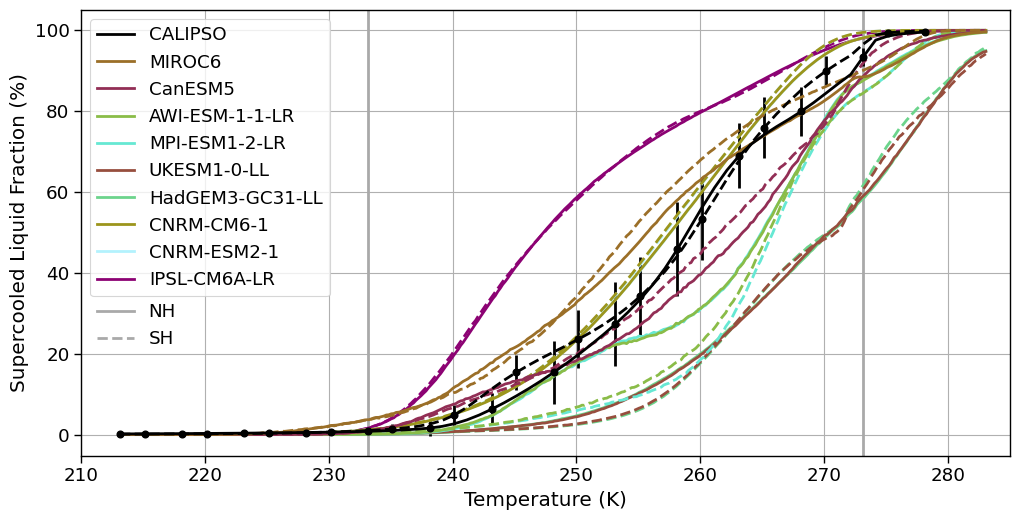

In [74]:
f, axsm = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=[10, 5])
# ax = axsm.flat
# colors = cm.hawaii(range(0, 256, int(256 / len(list(da['model'].unique()))) + 1))
cmap = cm.hawaiiS

# for (i, hemisphere) in enumerate(['north', 'south']):
axsm.axvline(x=273.15, ymin=0, ymax=1, color='darkgrey')
axsm.axvline(x=273.15-40, ymin=0, ymax=1, color='darkgrey')

# axsm.text(0.05, 0.95, f'{fct.fig_label[i]}', fontweight='bold', horizontalalignment='left', verticalalignment='top', transform=axsm.transAxes)
axsm.set_xlim([210, 285])

    

# axsm.fill_between(x=da_sat_NH.columns.values, y1=(da_sat_NH_mean-da_sat_NH_std).values, y2=(da_sat_NH_mean+da_sat_NH_std).values,
#                   color='k', alpha=0.25)
# axsm.fill_between(x=da_sat_SH.columns.values, y1=(da_sat_SH_mean-da_sat_SH_std).values, y2=(da_sat_SH_mean+da_sat_SH_std).values,
#                   color='k', alpha=0.25)
axsm.errorbar(x=da_sat_NH_mean.index[::5].values, y=da_sat_NH_mean[da_sat_NH_mean.index[::5]], yerr=da_sat_NH_std[da_sat_NH_std.index[::5]], fmt='o', color ='k', )
axsm.errorbar(x=da_sat_SH_mean.index[2::5].values, y=da_sat_SH_mean[da_sat_SH_mean.index[2::5]], yerr=da_sat_SH_std[da_sat_SH_std.index[2::5]], fmt='o', color ='k', )

# axsm.errorbar(x=da_sat_NH_mean.index.values, y=da_sat_SH_mean, yerr=da_sat_NH_std, errorevery=5, fmt='o', color ='k', )


# plot models
for c, model in zip(plt.cycler('color', cmap.colors), list(da['model'].unique())[::-1]):
        da_model = da[da['model'] == model]
        da_model[da['region'] =='north'].plot.line(ax=axsm, x='T', y='LCF_weighted_mean', label=model, color=c['color'])
        da_model[da['region'] =='south'].plot.line(ax=axsm, x='T', y='LCF_weighted_mean', label='_', color=c['color'], linestyle = '--')
# plot CloudSat
da_sat_NH_mean.plot(ax=axsm, label='CALIPSO', color='k')
da_sat_SH.mean(axis=0, skipna=True).plot(ax=axsm, label='_', color='k', linestyle = '--')

    
axsm.set_ylabel('Supercooled Liquid Fraction (%)') 
axsm.set_xlabel('Temperature (K)')
axsm.set_yticks(np.arange(0, 1.20,.20), np.arange(0, 120,20))
axsm.grid(True)
    
# Second legend lines
line_solid = fct.Line2D([], [], color='darkgray', linestyle='-', label='NH')
line_dashed = fct.Line2D([], [], color='darkgray', linestyle='--', label='SH')


h, l = axsm.get_legend_handles_labels()
first_legend = axsm.legend(handles=h[::-1], labels=l[::-1], loc=0)
ax = plt.gca().add_artist(first_legend)

second_legend = plt.legend(handles=[line_solid, line_dashed], loc=0, bbox_to_anchor=(-0.38, 0.05, 0.5, 0.33))
second_legend.set_frame_on(False)


plt.tight_layout(pad=0., w_pad=0., h_pad=0.)  ;
figname = f'T_vs_LCF_NH_SH.png'
plt.savefig(FIG_DIR + figname, format='png', bbox_inches='tight', transparent=True)

In [247]:
def find_temp_IQR_from_SLF_ratio(da_model, liquid_frac):
    # find the index where the model has e.g., 50% ice and 50% liquid in the lower quartile and upper quartile
    idx_lower = abs(da_model['LCF_0.25'] - liquid_frac).argmin()
    idx_upper = abs(da_model['LCF_0.75'] - liquid_frac).argmin()
    
    # use the index to locate the T5050 at the lower and upper quartile
    T_lower_q = da_model['T'].loc[idx_lower]
    T_upper_q = da_model['T'].loc[idx_upper]
    
    # IQR temperature variation for this model is the difference between the upper and lower temperature
    T = abs(T_upper_q - T_lower_q)
    
    return(T)


In [284]:
IQR_T_SH = pd.DataFrame(index=models,columns=['SLF 10%', 'SLF 50%', 'SLF 90%'])
IQR_T_NH = pd.DataFrame(index=models,columns=['SLF 10%', 'SLF 50%', 'SLF 90%'])

for model in list(models):
    # select the model from the dataset
    da_model = da[da['model'] == model]
    # select the hemisphere
    model_SH = da_model[da['region'] =='south']
    model_SH.reset_index(drop=True, inplace=True)
    
    model_NH = da_model[da['region'] =='north']
    model_NH.reset_index(drop=True, inplace=True)
    
    IQR_T_SH.loc[model]['SLF 50%'] = find_temp_IQR_from_SLF_ratio(model_SH, 0.5)
    IQR_T_SH.loc[model]['SLF 10%'] = find_temp_IQR_from_SLF_ratio(model_SH, 0.1)
    IQR_T_SH.loc[model]['SLF 90%'] = find_temp_IQR_from_SLF_ratio(model_SH, 0.9)
    
    IQR_T_NH.loc[model]['SLF 50%'] = find_temp_IQR_from_SLF_ratio(model_NH, 0.5)
    IQR_T_NH.loc[model]['SLF 10%'] = find_temp_IQR_from_SLF_ratio(model_NH, 0.1)
    IQR_T_NH.loc[model]['SLF 90%'] = find_temp_IQR_from_SLF_ratio(model_NH, 0.9)

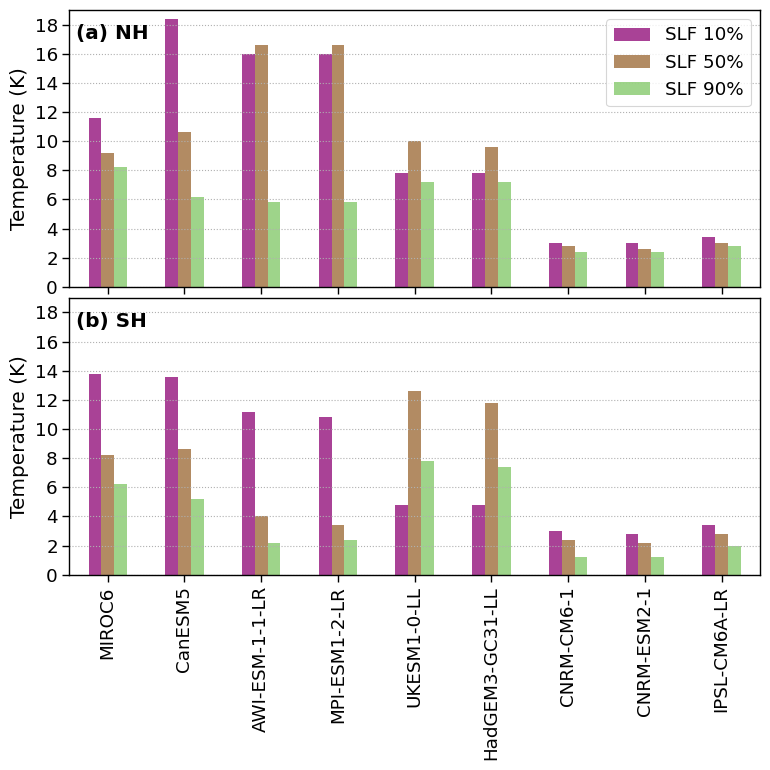

In [350]:
f, axsm = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=[7.5, 7.5])
colors = cm.hawaii(range(0, 256, int(256 / 3) + 1))
ax = axsm.flatten()


IQR_T_NH.plot.bar(ax=ax[0], color =colors, alpha=0.75)
IQR_T_SH.plot.bar(ax=ax[1], color =colors, alpha=0.75, legend=False)


for ax, k, hemisphere in zip(axsm.flatten(), range(len(fct.fig_label)), ['NH', 'SH']):
    ax.grid(axis='y', linestyle=':')
    ax.text(0.01, 0.95, f'{fct.fig_label[k]} {hemisphere}', fontweight='bold', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
    ax.set_ylabel('Temperature (K)')
    ax.set_ylim([0, 19])
    ax.set_yticks(np.arange(0,19,2))



plt.tight_layout(pad=0., w_pad=0., h_pad=0.)  ;
figname = f'IQR_T_SLF_NH_SH.png'
plt.savefig(FIG_DIR + figname, format='png', bbox_inches='tight', transparent=True)


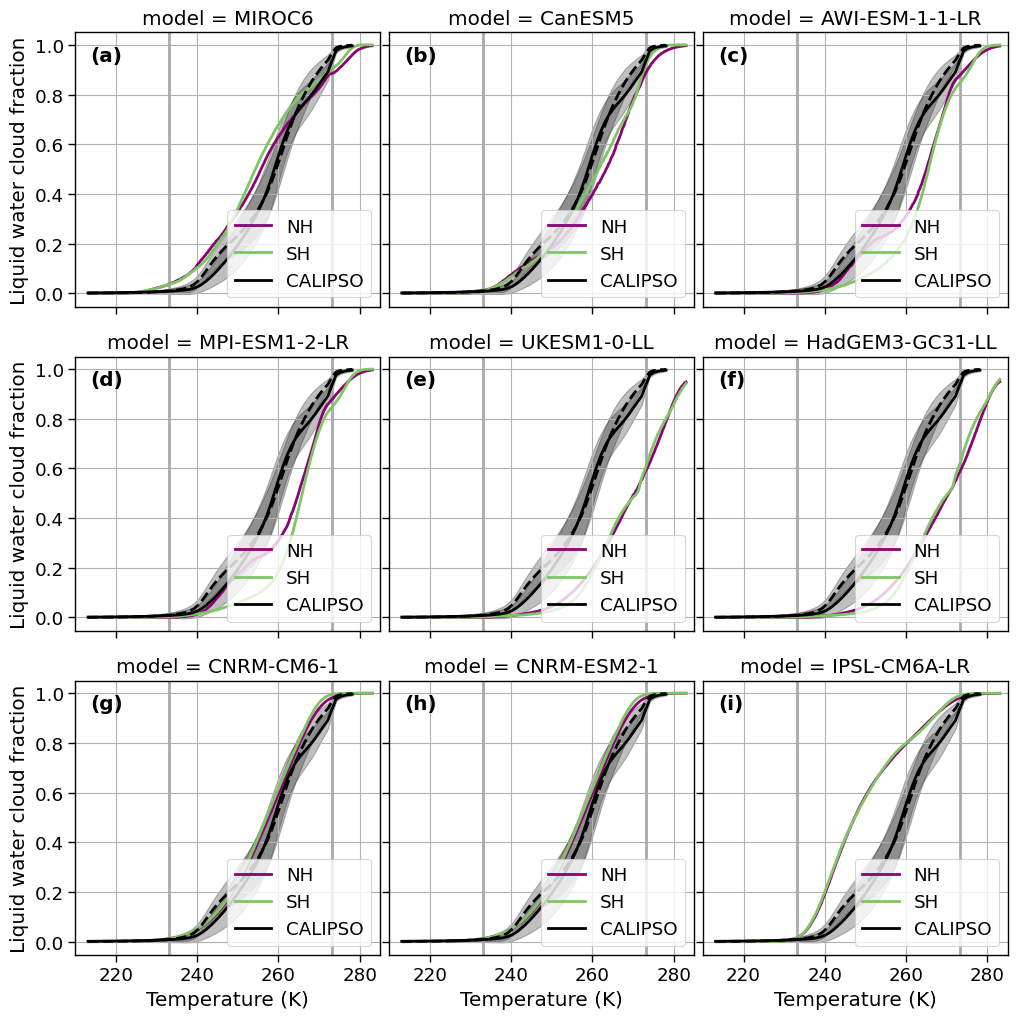

In [34]:
f, axsm = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=[10, 10])
colors = cm.hawaii(range(0, 256, int(256/3)+1))

for ax, model, k in zip(axsm.flatten(), list(da['model'].unique()), range(len(fct.fig_label))):
    ax.text(0.05, 0.95, f'{fct.fig_label[k]}', fontweight='bold', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
    
    ax.fill_between(x=da_sat_NH.columns.values, y1=(da_sat_NH_mean-da_sat_NH_std).values, y2=(da_sat_NH_mean+da_sat_NH_std).values,
                      color='k', alpha=0.25)
    ax.fill_between(x=da_sat_SH.columns.values, y1=(da_sat_SH_mean-da_sat_SH_std).values, y2=(da_sat_SH_mean+da_sat_SH_std).values,
                      color='k', alpha=0.25)
    
    ax.axvline(x=273.15, ymin=0, ymax=1, color='darkgrey')
    ax.axvline(x=273.15-40, ymin=0, ymax=1, color='darkgrey')
    ax.set_xlim([210, 285])
    
    ax.set_title(f'model = {model}')
    da_model = da[da['model'] == model]
    da_model[da['region'] =='north'].plot.line(ax=ax, x='T', y='LCF_weighted_mean', label='NH', color=colors[0])
    da_model[da['region'] =='south'].plot.line(ax=ax, x='T', y='LCF_weighted_mean', label='SH',  color=colors[2] )
    
    # plot CloudSat
    da_sat_NH_mean.plot(ax=ax, label='CALIPSO', color='k')
    da_sat_SH.mean(axis=0, skipna=True).plot(ax=ax, label='_', color='k', linestyle = '--')
    
    ax.set_ylabel('Liquid water cloud fraction') 
    ax.set_xlabel('Temperature (K)')
    ax.grid(True)
    ax.legend(loc=4)
    
plt.tight_layout(pad=0, w_pad=0., h_pad=1)  ;
figname = f'T_vs_LCF_models_seperate.png'
plt.savefig(FIG_DIR + figname, format='png', bbox_inches='tight', transparent=True)


In [ ]:
# file_pattern = f'{DATA_DIR}/output/CS_ERA5_CMIP6/orig/cloudsat_500_orig*.nc'
# files = sorted(glob(file_pattern))
# weights= xr.open_mfdataset(files)['areacella']
# weights
# dataset = ratios.sel(threshold=5)
# di = dataset[var_name+'_season'] - dataset[var_name+'_season'].sel(model='CloudSat')
# di_2 = np.sqrt(di)
# # di_2_mean = di_2.mean()
# lat_slice = slice(45,90)
# di_2_mean, _, _ = fct.calculate_stats(di_2, weights, lat_slice)
# # dataset[var_name+'_season_cs']
# np.sqrt(di_2_mean)

In [ ]:
# for var_name in ['FoS',]:#              'sf_eff', 'FLCC','FLCC-FsLCC','FsLCC',:
# # plot variable for individual model
#     fct.plt_spatial_season_all_models(ratios, var_name, dict_label, FIG_DIR, 45)
#     fct.plt_spatial_season_all_models(ratios_mci, var_name, dict_label, FIG_DIR_mci, 66)